In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if not torch.backends.mps.is_available():
    device = torch.device('cpu')
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

model_path = "cnn_best.pth"

img_x_size = int(335)
img_y_size = int(218)
num_channels = 1
input_size = img_x_size * img_y_size * num_channels
dropout_prob = 0.3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 20 output channels, 5x5 square convolution
        # kernel
        in1 = 1
        out1 = 20
        self.conv1 = nn.Conv2d(in1, out1, (5,5))
        self.bn1 = nn.BatchNorm2d(out1)
        # self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)

        out2 = 40
        self.conv2 = nn.Conv2d(out1, out2, (5,5))
        self.bn2 = nn.BatchNorm2d(out2)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2d = nn.Dropout2d(p=dropout_prob)

        out3 = 80
        self.conv3 = nn.Conv2d(out2, out3, (5,5))
        self.bn3 = nn.BatchNorm2d(out3)
        # self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(out3 * 101 * 159, 500)
        self.bn4 = nn.BatchNorm1d(500)

        self.fc2 = nn.Linear(500, 100)
        self.bn5 = nn.BatchNorm1d(100)

        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # TODO: try batchnorm vs max pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # x = self.mp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2d(x)
        x = self.mp2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [3]:
net = Net()

# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
total_params

642513730

In [4]:
from util import load_data_from_split
split_songs = False
train_loader, val_loader, test_loader = load_data_from_split(resize_images=False, batch_size=10, split_songs=split_songs)

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from util import train_loop

net = Net()
num_epochs = 20
criterion = nn.CrossEntropyLoss() # loss function

optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0, weight_decay=1e-5)

scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=(num_epochs/2)*len(train_loader), step_size_down=(num_epochs/2)*len(train_loader), mode='triangular')

training_losses, validation_losses = train_loop(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    model_path=model_path,
    split_songs=split_songs,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler
)

Epoch 1 | LR: 1.00e-05 -> 5.09e-04 | Train Loss: 2.040 | Val Loss: 1.590 | Val Acc: 54.00%
Epoch 2 | LR: 5.09e-04 -> 1.01e-03 | Train Loss: 1.502 | Val Loss: 1.487 | Val Acc: 56.00%
Epoch 3 | LR: 1.01e-03 -> 1.51e-03 | Train Loss: 0.941 | Val Loss: 1.387 | Val Acc: 59.00%
Epoch 4 | LR: 1.51e-03 -> 2.01e-03 | Train Loss: 0.523 | Val Loss: 1.307 | Val Acc: 57.00%
Epoch 5 | LR: 2.01e-03 -> 2.51e-03 | Train Loss: 0.266 | Val Loss: 1.299 | Val Acc: 58.00%
Epoch 6 | LR: 2.51e-03 -> 3.00e-03 | Train Loss: 0.166 | Val Loss: 1.209 | Val Acc: 59.00%
Epoch 7 | LR: 3.00e-03 -> 3.50e-03 | Train Loss: 0.161 | Val Loss: 1.378 | Val Acc: 51.00%
Epoch 8 | LR: 3.50e-03 -> 4.00e-03 | Train Loss: 0.136 | Val Loss: 1.277 | Val Acc: 54.00%
Epoch 9 | LR: 4.00e-03 -> 4.50e-03 | Train Loss: 0.127 | Val Loss: 1.351 | Val Acc: 55.00%
Epoch 10 | LR: 4.50e-03 -> 5.00e-03 | Train Loss: 0.135 | Val Loss: 1.329 | Val Acc: 51.00%
Epoch 11 | LR: 5.00e-03 -> 4.50e-03 | Train Loss: 0.088 | Val Loss: 1.364 | Val Acc: 54.0

KeyboardInterrupt: 

In [6]:
from util import test_model, test_model_aggregate

net = Net()
net.to(device)

# Load the best saved model weights
net.load_state_dict(torch.load(f"models/{model_path}"))

test_accuracy, test_loss = test_model(net, test_loader, device, criterion)

results_str = f"Test Accuracy | Idv: {test_accuracy:.2f}%"
if(split_songs):
    test_accuracy_agg = test_model_aggregate(net, test_loader, device)
    results_str += f", Agg: {test_accuracy_agg:.2f}%"

print(results_str)

Test Accuracy | Idv: 45.00%


[2.0651879087090492, 1.5565270811319352, 1.1501576997339726, 0.8610884010791778, 0.6269722692668438, 0.4535232223570347, 0.38931680787354705, 0.3002007920295, 0.26247171461582186, 0.23105614297091961, 0.16744997045025228, 0.13783792462199926, 0.12735741999931632, 0.12401150353252888, 0.1157111065927893, 0.0962522966787219, 0.08756489716470242, 0.08254333361983299, 0.0843847447540611, 0.08385852468200028] [1.6706487774848937, 1.650232696533203, 1.5483234167098998, 1.523197239637375, 1.4952925205230714, 1.4362736701965333, 1.4417453289031983, 1.4196441769599915, 1.4236327171325684, 1.3920845627784728, 1.3909929037094115, 1.3718422830104828, 1.3741445541381836, 1.462186062335968, 1.3835236072540282, 1.3757495999336242, 1.3259847581386566, 1.3647912859916687, 1.378979742527008, 1.3552342176437377]


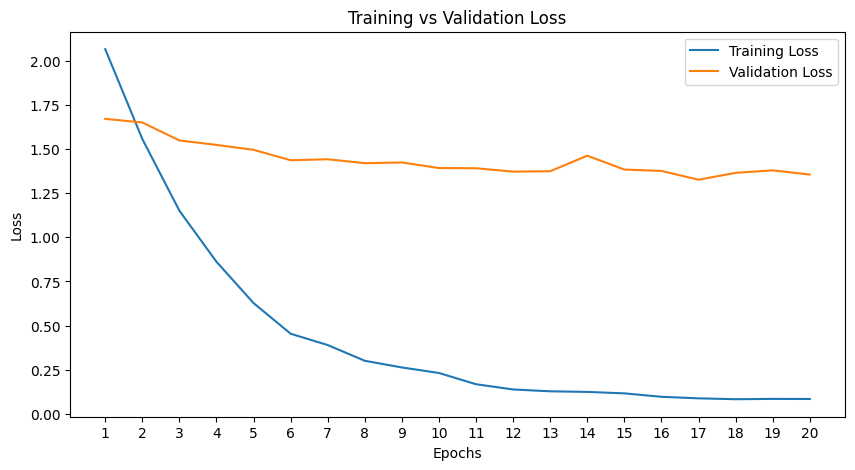

In [7]:
from util import plot_loss
print(training_losses, validation_losses)
plot_loss(training_losses, validation_losses)